# Tutorial for TSP Problem

## Write TSP mathematical model with jijmodeling
通常、QAOAやVQEなどの量子アルゴリズムで数理最適化問題を解くのに必要な基本的なステップは
1. 数理モデルを記述する
2. 数理モデルをQUBO形式へと変換する
3. QUBO形式をIsing形式へと変換する
である。
ここでは、これらのステップを具体的にTSPを用いて見ていく。

まずは、TSPの数理モデルを記述してみよう。
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n}\\
\mathrm{s.t.}~&\sum_i x_{i, t} = 1,~\forall t\\
&\sum_t x_{i, t} = 1, ~\forall i\\
&x_{i, t} \in \{0, 1\}
\end{aligned}
$$
where $d_{i,j}$ is distance between city $i$ and city $j$.
数理モデルの詳細な説明は省くが、ここで重要なのは、ただ数理モデルを記述しただけでは量子アルゴリズムで扱える形ではない点である。

次に、数理モデルをQuadratic Unconstraint Binary Optimization(QUBO)形式に変換する必要がある。
QUBO形式への変換として典型的なものには、Penalty法がある。これは数理モデルを以下のような形に変換する手法である。
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n} + \sum_t \mu_t \left(\sum_i x_{i, t} - 1\right)^2 + \sum_i \lambda_i \left(\sum_t x_{i, t} - 1 \right)^2\\
\end{aligned}
$$

最後に、このQUBO形式をIsing形式に変換する必要がある。
つまり、バイナリ変数を$x_i = \frac{1}{2}(1 - z_i)$のようにスピン変数へと変換してQUBO形式をIsing形式に変換する必要がある。
ここでは、具体的な計算は面倒なので書かないが形式的には、以下のような変換になる
$$
\begin{aligned}
\sum_{i,j} Q_{i,j}x_i,x_j \to \sum_{i,j}J_{i,j}z_iz_j + \sum_ih_i z_i 
\end{aligned}
$$
さて、上記から分かるように数理モデルを簡単な量子アルゴリズムで解けるように変換するだけで、なかなか面倒である。

そこで、上記の変換の面倒さを自動で行うツールが`jijtranspiler_qiskit`である。

以下で具体的な使い方を見てみよう。

In [1]:
import jijmodeling as jm
import jijmodeling.transpiler as jmt
from jijtranspiler_qiskit.qaoa import transpile_to_qaoa_ansatz

import qiskit as qk
import numpy as np
import matplotlib.pyplot as plt

まずは、JijModelingを用いて数理モデルを記述する。

ここでは、数理モデルに用いる変数などを定義し、それらの変数を用いて目的関数や制約条件記述していく。

In [2]:
# define variables
d = jm.Placeholder('d', dim=2)
N = d.shape[0].set_latex("N")
i = jm.Element('i', (0, N))
j = jm.Element('j', (0, N))
t = jm.Element('t', (0, N))
x = jm.Binary('x', shape=(N, N))

# set problem
problem = jm.Problem('TSP')
problem += jm.Sum([i, j], d[i, j] * jm.Sum(t, x[i, t]*x[j, (t+1) % N]))
problem += jm.Constraint("one-city", jm.Sum(i,x[i, t]) == 1, forall=t)
problem += jm.Constraint("one-time", jm.Sum(t,x[i, t]) == 1, forall=i)
problem

/home/azureuser/MatsuyamaSandbox/transpiler_qiskit/jmtranspiler-qiskit/.venv/lib/python3.9/site-packages/jijmodeling/expression/sum.py:175: TypeHintWarning: Cannot resolve forward reference 'IndexType'
  def convert_to_element(
/home/azureuser/MatsuyamaSandbox/transpiler_qiskit/jmtranspiler-qiskit/.venv/lib/python3.9/site-packages/jijmodeling/expression/constraint.py:258: TypeHintWarning: Cannot resolve forward reference 'IndexType'
  def convert_to_element(


JijModelingを用いると、上記のように数理モデルをTex形式で確認することができ、自分がプログラムした数理モデルと手元に書いた数理モデルが一致しているかを確認しながら記述していくことができる。

## Generate instance and check with jijbench

次に、実際に問題を解くために簡単な問題を作成しておく。
ここでは、例としてRandomに配置した3都市のTSPを解くことにする。

In [3]:
def generate_random_instance(n):
    x_pos = np.random.rand(n)
    y_pos = np.random.rand(n)
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2)
    return x_pos, y_pos, distance

In [4]:
x_pos, y_pos, distance = generate_random_instance(4)

ここで可視化のためにJijBenchという、Jijが作成している数理最適化の実験管理ツールに入っている可視化機能を用いる。

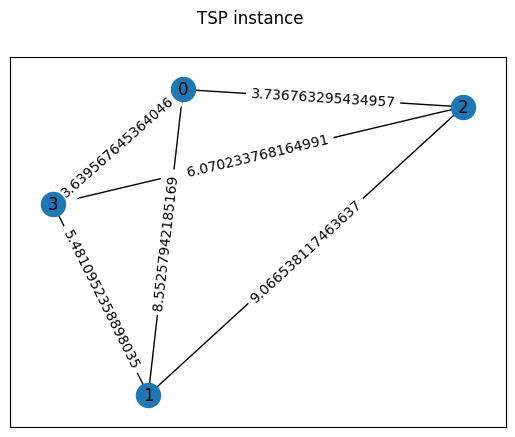

In [5]:
from jijbench.visualization import Graph,GraphType

graph = Graph.from_distance_matrix(distance,graphtype=GraphType.UNDIRECTED)
node_pos = {i:(x,y) for i,(x,y) in enumerate(zip(x_pos,y_pos))}
graph.show(node_pos=node_pos,title="TSP instance")

## Generate Qiskit Hamiltonian with jijtranspiler_qiskit

続いて、実際に数理モデルを変換していく。ここでは、Qiskitで解けるように変換する。
まず初めに、作成した数理モデルと問題インスタンスを与えて、数理モデルを内部で処理できるように変換する。

In [6]:
compiled_instance = jmt.core.compile_model(problem, {"d": distance})

/home/azureuser/MatsuyamaSandbox/transpiler_qiskit/jmtranspiler-qiskit/.venv/lib/python3.9/site-packages/jijmodeling/utils/deprecated.py:14: FutureWarning: with_multiplier is deprecated. This optional argument will be removed in the next version.
  warnings.warn(f"{arg_name} is deprecated. " + additional_msg, FutureWarning)
/home/azureuser/MatsuyamaSandbox/transpiler_qiskit/jmtranspiler-qiskit/.venv/lib/python3.9/site-packages/jijmodeling/utils/deprecated.py:14: FutureWarning: with_penalty is deprecated. This optional argument will be removed in the next version.
  warnings.warn(f"{arg_name} is deprecated. " + additional_msg, FutureWarning)
/home/azureuser/MatsuyamaSandbox/transpiler_qiskit/jmtranspiler-qiskit/.venv/lib/python3.9/site-packages/jijmodeling/utils/deprecated.py:14: FutureWarning: auto_qubo is deprecated. This optional argument will be removed in the next version.
  warnings.warn(f"{arg_name} is deprecated. " + additional_msg, FutureWarning)
/home/azureuser/MatsuyamaSandbo

次に、QAOA Ansatzを作成するために、どのようにQUBOに変換するかなどの情報を設定する。
例えば、どのように数理モデルをQUBOへ変換するかも設定することができる。上記のようなPenalty法やAugument Lagrangian methodを用いても変換することができる。

Augumented Lagrangian Method : Adding Linear and Quadratic term to Objective function
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n} + \sum_t \xi_t \left(\sum_i x_{i, t} - 1\right) + \sum_t \mu_t \left(\sum_i x_{i, t} - 1\right)^2 + \sum_i \zeta_i \left(\sum_t x_{i, t} - 1 \right) +  \sum_i \lambda_i \left(\sum_t x_{i, t} - 1 \right)^2\\
\end{aligned}
$$

In [7]:
qaoa_builder = transpile_to_qaoa_ansatz(compiled_instance,relax_method = jmt.core.pubo.RelaxationMethod.SquaredPenalty)

# You can also use Augumented Lagrangian method to build QUBO
# qaoa_builder = transpile_to_qaoa_ansatz(compiled_instance,relax_method = jmt.core.pubo.RelaxationMethod.AugmentedLagrangian)

最後に `get_qaoa_ansatz`を用いることで、qaoaのparametrized circuitや目的関数等を得ることができる。
また、この際にQAOAのレイヤー数や、上記のPenalty法の係数なども細かく設定することができる。(Default valueは1である。)

In [8]:
qaoa_ansatz, cost_func, constant = qaoa_builder.get_qaoa_ansatz(p=1,detail_parameters = {'one-city':{(1,): (2, 1)},'one-time':{(1,): (2, 1)}})

ここまででqiskitのQAOAのサーキットが得られたので、以降はqiskitを用いてプログラミングを行うことができる。

In [9]:
qaoa_ansatz.measure_all()
qaoa_ansatz.decompose().draw('text')

┌───┐»
    q_0: ┤ H ├»
         ├───┤»
    q_1: ┤ H ├»
         ├───┤»
    q_2: ┤ H ├»
         ├───┤»
    q_3: ┤ H ├»
         ├───┤»
    q_4: ┤ H ├»
         ├───┤»
    q_5: ┤ H ├»
         ├───┤»
    q_6: ┤ H ├»
         ├───┤»
    q_7: ┤ H ├»
         ├───┤»
    q_8: ┤ H ├»
         ├───┤»
    q_9: ┤ H ├»
         ├───┤»
   q_10: ┤ H ├»
         ├───┤»
   q_11: ┤ H ├»
         ├───┤»
   q_12: ┤ H ├»
         ├───┤»
   q_13: ┤ H ├»
         ├───┤»
   q_14: ┤ H ├»
         ├───┤»
   q_15: ┤ H ├»
         └───┘»
meas: 16/═════»
              »
«         ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«    q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [10]:
cost_func

SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZZIIII', 'IIIIIIIIZZIIIIII', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIZIIII', 'IIIIZIIIIZIIIIII', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIZII', 'IZIIIIIIIIIZIIII', 'ZIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIZIIZIII', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIZZIIIIIII', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIZIII', 'IIIIZIIIIIZIIIII', 'IIIZIIIIZIIIIIII', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIZIII', 'ZIIIIIIIIIZIIIII', 'IIIIZIIIIIIIIZII', 'IIIIIIIZIIIZIIII', 'IIIIIIZIIZIIIIII', 'IIIIIZIIIIIIIIIZ', 'IIIIZIIIIIIIIIZI', 'IIIIIIIZIIIIZIII', 'IIIIIIZIIIZIIIII', 'IIIIIZIIZIIIIIII', 'IIIZZIIIIIIIIIII', 'IIZI

# QAOAを実行してみる。

In [11]:
from qiskit.primitives import Estimator, Sampler
from scipy.optimize import minimize

`transpiler_qiskit`を用いて、Ansatzとハミルトニアンを作成する。

In [12]:
qaoa_ansatz, hamiltonian, constant = qaoa_builder.get_qaoa_ansatz(p=1,multipliers = {'one-city':1,'one-time':1})

コスト関数を定義する。ここでは、`qiskit.primitive`の`Estimator`を用いて、期待値を計算する。

In [13]:
def cost_func(parameters, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=parameters).result().values[0]
    return cost

In [14]:
initial_params = [1.0, 0.6]
estimator = Estimator()
optimization_history = []
qaoa_result = minimize(cost_func, initial_params, args=(qaoa_ansatz, hamiltonian, estimator), method='COBYLA',callback = lambda x:optimization_history.append(cost_func(x,qaoa_ansatz, hamiltonian, estimator)))

パラメータの最適化の結果、期待値が減少していることが分かる。

Text(0, 0.5, 'cost function')

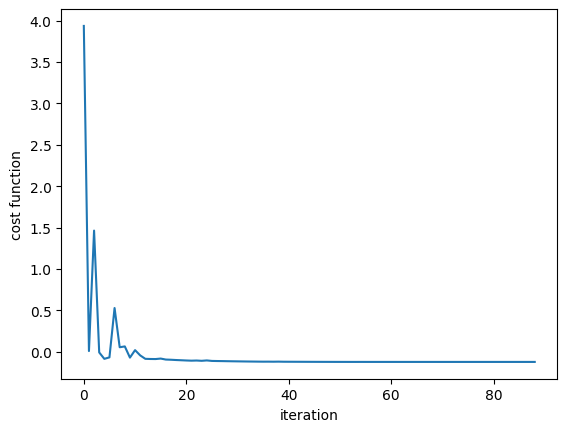

In [15]:
plt.plot(optimization_history)
plt.xlabel('iteration')
plt.ylabel('cost function')

次に、得られた最適なパラメータを用いて解をSamplingする。

In [16]:
qaoa_ansatz.measure_all()

In [17]:

sampler = Sampler()
job = sampler.run(qaoa_ansatz, qaoa_result.x)
result = job.result().quasi_dists
decoded_results = qaoa_builder.decode_from_quasi_dist(result[0])
print(decoded_results)

`transpiler_qiskit`を用いて得られたハミルトニアンに関するサンプリング結果に関しては、decode機能を用いることで、より見やすく解析しやすい形に変換することができる。
例えば、decodeして得られた結果は`feasible` methodを使うことで、実行可能解のみを抜き出すことができる。

In [ ]:
feasible_result = decoded_results.feasible()
feasible_result.to_dense()

SampleSet(record=Record(solution={'x': [array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]]), array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]]), array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]]), array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]]), array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])]}, num_occurrences=[0, 0, 0, 0, 0, 0]), evaluation=Evaluation(energy=None, objective=[14.863046548214966, 14.863046548214966, 14.863046548214966, 14.863046548214966, 14.863046548214966, 14.863046548214966], constraint_violations={'one-city': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'one-time': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_

得られた実行可能解についてどのような、tourがどのような目的関数値になっているかを見てみる。

In [ ]:
import networkx as nx
def plot_tour(ax,G,node_pos):
    nx.draw_networkx_nodes(
            G=G,
            pos=node_pos,
            ax=ax,
        )
    nx.draw_networkx_edges(
            G=G,
            pos=node_pos,
            ax=ax,
        )
    node_labels = {node: str(node) for node in G.nodes}
    nx.draw_networkx_labels(
            G=G,
            pos=node_pos,
            labels=node_labels,
            ax=ax,
        )

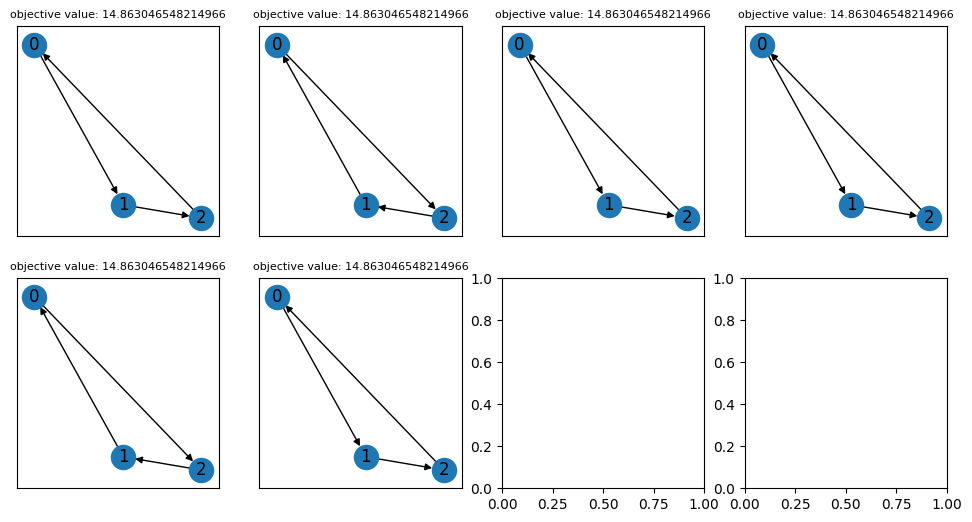

In [ ]:
# 画像を横に並べるための設定
num_images = len(feasible_result)
columns = 4  # 一行に表示する画像の数
rows = (num_images - 1) // columns + 1  # 行数の計算

# 画像を横並びに表示するためのサブプロットの設定
fig, axes = plt.subplots(rows, columns, figsize=(12, 3*rows))

for i, objective_value in enumerate(feasible_result.evaluation.objective):
    ax = axes[i // columns, i % columns] 
    (time_order, route), value,matrix_shape = decoded_results.feasible().record.solution['x'][i]
    edge = [[route[i],route[i+1]] for i in range(len(route)-1)] + [[route[-1],route[0]]]
    graph = Graph.from_edge_list(edge_list=edge,graphtype=GraphType.DIRECTED)
    plot_tour(ax=ax,G=graph.G,node_pos=node_pos)
    ax.set_title(f"objective value: {objective_value}",fontsize=8)